# IceCube - EDA

## Load Data

In [1]:
%cd ..

/home/jovyan/working


In [2]:
import sys

sys.path.append(".")

In [3]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [4]:
import glob
import math
import os
import re

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import euclidean, pdist, squareform, cdist

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [5]:
from src.ice_cube.data_loader import make_dataloader_batch
from src.ice_cube.model import load_pretrained_model
from src.ice_cube.scoring import angular_dist_score
from src.load_data import LoadData
from src.preprocesses.cache import fit_instance, transform_data
from src.preprocesses.p001_dist_transformer import DistTransformer
from src.ice_cube.submission import to_submission_df
from src.utils import choice_seed, df_stats, fix_seed

graphnet: INFO     2023-03-28 04:33:01 - get_logger - Writing log to logs/graphnet_20230328-043301.log


2023-03-28 04:33:01,577 [INFO] [logging] Writing log to logs/graphnet_20230328-043301.log


graphnet: WARNING  2023-03-28 04:33:01 - warn_once - `icecube` not available. Some functionality may be missing.


2023-03-28 04:33:01,583 [WARNING] [logging] `icecube` not available. Some functionality may be missing.
/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")
2023-03-28 04:33:02.797778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 04:33:02.970378: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set th

In [6]:
# Competition specific packages
import os
import sqlite3
from typing import Any, Dict, List, Optional

import pyarrow.parquet as pq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from graphnet.data.constants import FEATURES, TRUTH
from graphnet.data.sqlite import SQLiteDataset

# import sqlalchemy
# import graphnet
# from graphnet.data.sqlite.sqlite_utilities import create_table

In [7]:
c_main = OmegaConf.load("./config/main.yaml")
c_data = OmegaConf.load("./config/data.yaml")
c = OmegaConf.merge(c_main, c_data)

fix_seed(choice_seed(c))

2023-03-28 04:33:06,254 [INFO] [utils] Fix seed: 440


In [8]:
input = LoadData(c, use_fold=False, do_preprocess=False)

2023-03-28 04:33:06,260 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/train_meta.parquet
2023-03-28 04:33:16,154 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/test_meta.parquet
2023-03-28 04:33:16,159 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
2023-03-28 04:33:16,162 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv


In [9]:
[col for col in dir(input) if not col.startswith("__")]

['c', 'sample_submission', 'sensor_geometry', 'test_meta', 'train_meta']

In [10]:
results = pd.read_csv("results.csv")
submission_df = pd.read_csv("submission.csv")

## Check Data

In [11]:
input.sample_submission

,event_id,azimuth,zenith
0,2092,1,1
1,7344,1,1
2,9482,1,1


In [13]:
input.sensor_geometry["string_id"] = input.sensor_geometry["sensor_id"] // 60
input.sensor_geometry["depth_id"] = input.sensor_geometry["sensor_id"] % 60

In [28]:
# 0: main sensor
# 1: Veto cap
# 2: DeepCore
# 3: Dust layer
input.sensor_geometry.loc[input.sensor_geometry["string_id"] < 78, "sensor_type"] = 0
input.sensor_geometry.loc[(input.sensor_geometry["string_id"] >= 78) & (input.sensor_geometry["depth_id"] < 10), "sensor_type"] = 1
input.sensor_geometry.loc[(input.sensor_geometry["string_id"] >= 78) & (input.sensor_geometry["depth_id"] >= 10), "sensor_type"] = 2
input.sensor_geometry.loc[(input.sensor_geometry["z"] >= -155) & (input.sensor_geometry["z"] <= 0), "sensor_type"] = 3

In [29]:
input.sensor_geometry

,sensor_id,x,y,z,sensor_type,string_id,depth_id
0,0,-256.14,-521.08,496.03,0,0,0
1,1,-256.14,-521.08,479.01,0,0,1
2,2,-256.14,-521.08,461.99,0,0,2
3,3,-256.14,-521.08,444.97,0,0,3
4,4,-256.14,-521.08,427.95,0,0,4
...,...,...,...,...,...,...,...
5155,5155,-10.97,6.72,-472.39,2,85,55
5156,5156,-10.97,6.72,-479.39,2,85,56
5157,5157,-10.97,6.72,-486.40,2,85,57
5158,5158,-10.97,6.72,-493.41,2,85,58


In [30]:
input.sensor_geometry["sensor_type"].value_counts()

0    3978
3     702
2     400
1      80
Name: sensor_type, dtype: int64

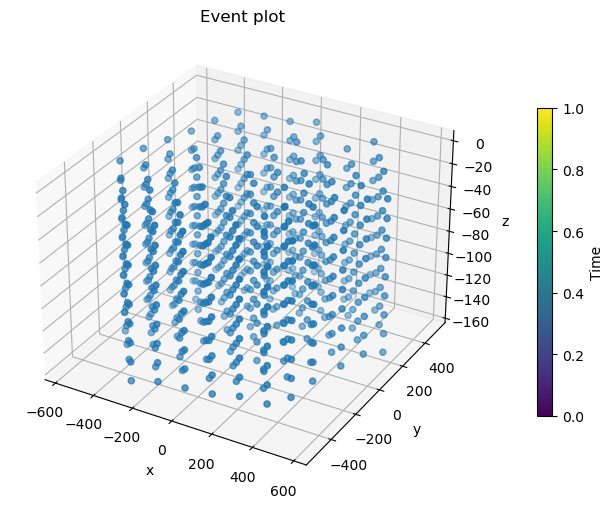

In [31]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

#ax.set_xticks([-600, -300, 0.0, 300, 600])
#ax.set_yticks([-600, -300, 0.0, 300, 600])
#ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    input.sensor_geometry[input.sensor_geometry["sensor_type"] == 3]["x"],
    input.sensor_geometry[input.sensor_geometry["sensor_type"] == 3]["y"],
    input.sensor_geometry[input.sensor_geometry["sensor_type"] == 3]["z"],
    #s=batch_event_["charge"] * 50,
    #c=batch_event_["time"],
)

cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

In [27]:
input.sensor_geometry[input.sensor_geometry["sensor_type"] == 1]["depth_id"].value_counts()

0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
8    8
9    8
Name: depth_id, dtype: int64

In [13]:
input.test_meta

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [14]:
input.train_meta

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
...,...,...,...,...,...,...
131953919,660,2147483597,24339210,24339349,5.895612,0.333071
131953920,660,2147483603,24339350,24339383,3.273695,1.503301
131953921,660,2147483617,24339384,24339424,2.945376,1.723253
131953922,660,2147483626,24339425,24339499,1.616582,1.937025


## Read single batch

In [15]:
batch_num = 401
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_train, f"batch_{batch_num}.parquet")
).reset_index()

In [16]:
batch

,event_id,sensor_id,time,charge,auxiliary
0,1302060142,218,6135,1.275,True
1,1302060142,4907,6220,0.975,True
2,1302060142,1727,6361,1.075,True
3,1302060142,1958,6522,0.675,True
4,1302060142,2889,6729,0.975,True
...,...,...,...,...,...
31848138,1305313876,2142,22242,0.825,True
31848139,1305313876,1013,22404,0.925,True
31848140,1305313876,4161,22411,1.275,True
31848141,1305313876,3863,22760,1.175,True


In [17]:
batch = pd.merge(batch, input.sensor_geometry, on="sensor_id")

In [18]:
batch

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,1302060142,218,6135,1.275,True,114.39,-461.99,-148.12
1,1302060797,218,10041,1.075,True,114.39,-461.99,-148.12
2,1302061627,218,11611,1.775,True,114.39,-461.99,-148.12
3,1302062837,218,10994,0.525,False,114.39,-461.99,-148.12
4,1302064830,218,9861,0.875,True,114.39,-461.99,-148.12
...,...,...,...,...,...,...,...,...
31848138,1305309738,2886,8143,0.675,True,472.05,127.90,402.15
31848139,1305313276,2886,10027,0.275,False,472.05,127.90,402.15
31848140,1305313276,2886,10037,0.875,False,472.05,127.90,402.15
31848141,1305313276,2886,10215,0.925,False,472.05,127.90,402.15


## Single Event

In [19]:
event_id = 1302060142

In [20]:
azimuth_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "azimuth"
].to_numpy()
zenith_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "zenith"
].to_numpy()
azimuth_event, zenith_event

(array([3.34480774]), array([2.50266621]))

In [21]:
line_x = math.cos(azimuth_event) * math.sin(zenith_event)
line_x_details = (-line_x * 500, line_x * 500)
line_y = math.sin(azimuth_event) * math.sin(zenith_event)
line_y_details = (-line_y * 500, line_y * 500)
line_z = math.cos(zenith_event)
line_z_details = (-line_z * 500, line_z * 500)
line_color, line_style, line_width = "r", "-", 2

In [22]:
batch_event = batch[(batch["event_id"] == event_id)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["auxiliary"] == False)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["charge"] < 1)]
batch_event.shape

(66, 8)

In [23]:
batch_event.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,1302060142,218,6135,1.275,True,114.39,-461.99,-148.12
5625,1302060142,4907,6220,0.975,True,106.94,27.09,-420.08
16002,1302060142,1727,6361,1.075,True,371.56,-92.18,-297.39
22831,1302060142,1958,6522,0.675,True,-324.39,-93.43,-146.65
22832,1302060142,1958,10048,0.225,True,-324.39,-93.43,-146.65


In [24]:
batch_event["auxiliary"].value_counts()

True     49
False    17
Name: auxiliary, dtype: int64

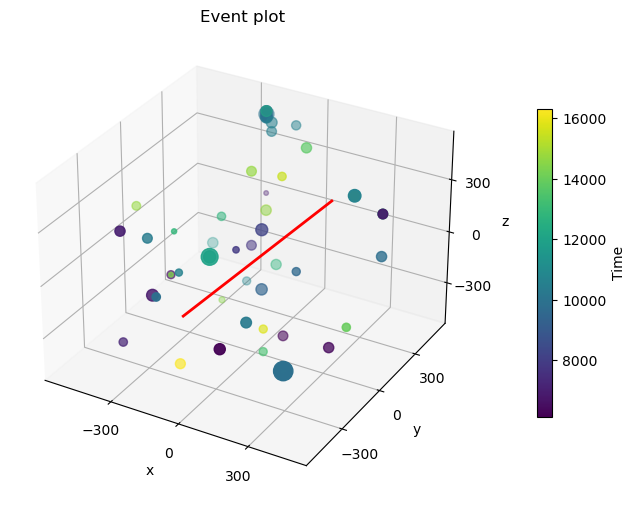

In [25]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event["x"],
    batch_event["y"],
    batch_event["z"],
    s=batch_event["charge"] * 50,
    c=batch_event["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

### 階層的クラスタリング

In [26]:
time_dist = pdist(batch_event[["time"]])
space_dist = pdist(batch_event[["x", "y", "z"]])

# h_cluster = linkage(space_dist / (time_dist * 0.3 + 1e-8))
h_cluster = linkage(space_dist / (time_dist * 0.3 / 1.309 + 1e-8))

In [27]:
# batch_event.loc[:, "time"] = (batch_event["time"] - 1e4) / 3e4
# batch_event.loc[:, ["x", "y", "z"]] = batch_event[["x", "y", "z"]] / 500.0

# h_cluster = linkage(batch_event[["time", "x", "y", "z"]])

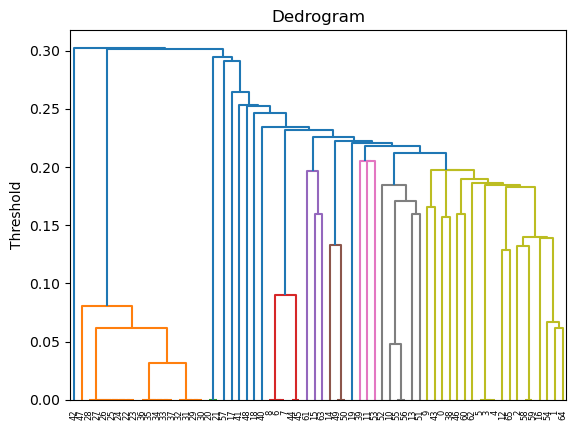

In [28]:
dendrogram(h_cluster)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

In [29]:
# batch_event.loc[:, "h_labels"] = fcluster(h_cluster, 0.01, criterion="distance")
batch_event.loc[:, "h_labels"] = fcluster(h_cluster, 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [30]:
batch_event["h_labels"].value_counts().idxmax()

17

In [31]:
batch_event["h_labels"].value_counts()

17    7
1     7
11    6
2     5
3     4
15    3
6     3
10    3
9     3
8     3
13    2
14    2
7     2
5     2
16    2
12    2
19    1
21    1
24    1
20    1
23    1
26    1
4     1
22    1
25    1
18    1
Name: h_labels, dtype: int64

In [32]:
#batch_event_ = batch_event[batch_event.duplicated(subset=["h_labels"], keep=False)]
batch_event_ = batch_event[
    batch_event["h_labels"] == batch_event["h_labels"].value_counts().idxmax()
]

In [33]:
batch_event_.shape

(7, 9)

In [34]:
# batch_event_.loc[:, ["x", "y", "z"]] = batch_event_[["x", "y", "z"]] * 500.0

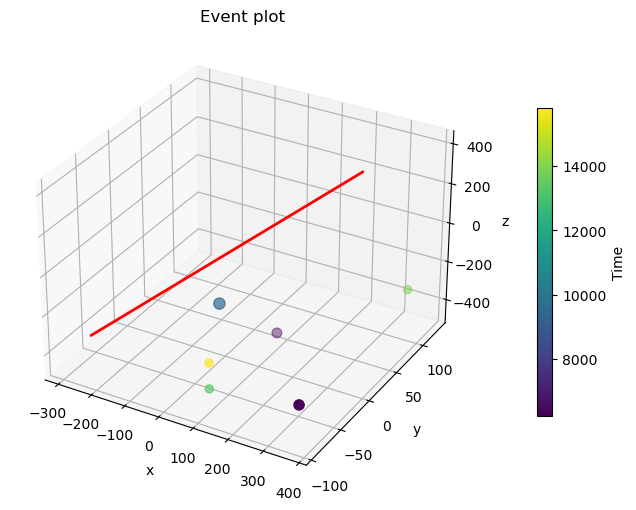

In [35]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

#ax.set_xticks([-600, -300, 0.0, 300, 600])
#ax.set_yticks([-600, -300, 0.0, 300, 600])
#ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event_["x"],
    batch_event_["y"],
    batch_event_["z"],
    s=batch_event_["charge"] * 50,
    c=batch_event_["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

## Validation


In [36]:
results.columns, valid_df.columns, submission_df.columns

(Index(['Unnamed: 0', 'event_id', 'direction_x', 'direction_y', 'direction_z',
        'direction_kappa', 'zenith', 'azimuth', 'sigma'],
       dtype='object'),
 Index(['event_id', 'azimuth', 'zenith'], dtype='object'),
 Index(['event_id', 'azimuth', 'zenith'], dtype='object'))

In [17]:
def angular_dist_df(az_true, zen_true, az_pred, zen_pred):
    if not (
        np.all(np.isfinite(az_true))
        and np.all(np.isfinite(zen_true))
        and np.all(np.isfinite(az_pred))
        and np.all(np.isfinite(zen_pred))
    ):
        raise ValueError("All arguments must be finite")

    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)

    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)

    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1 * sz2 * (ca1 * ca2 + sa1 * sa2) + (cz1 * cz2)

    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod = np.clip(scalar_prod, -1, 1)

    # convert back to an angle (in radian)
    return np.abs(np.arccos(scalar_prod))

In [38]:
score = angular_dist_df(valid_df["azimuth"], valid_df["zenith"], submission_df["azimuth"], submission_df["zenith"])

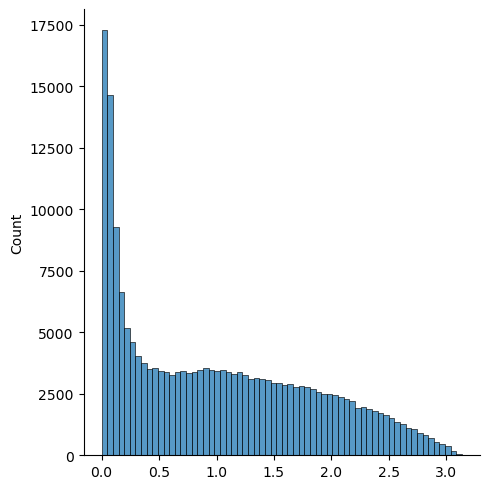

In [39]:
sns.displot(score)

## Debug

In [35]:
results_low_sigma = results[results["sigma"] <= 0.5]
results_high_sigma = results[results["sigma"] > 0.5]

In [36]:
results_low_sigma.shape, results_high_sigma.shape

((51599, 11), (148401, 11))

In [23]:
score_low_sigma = angular_dist_df(
    results_low_sigma["azimuth_y"],
    results_low_sigma["zenith_y"],
    submission_low_sigma["azimuth"],
    submission_low_sigma["zenith"],
)
score_high_sigma = angular_dist_df(
    results_high_sigma["azimuth_y"],
    results_high_sigma["zenith_y"],
    submission_high_sigma["azimuth"],
    submission_high_sigma["zenith"],
)

sigma が小さいものは予測精度がよい。

sigma が大きいものは予測精度が悪い。

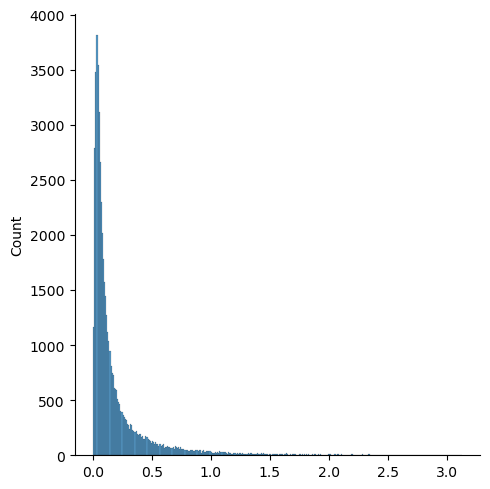

In [24]:
sns.displot(score_low_sigma)

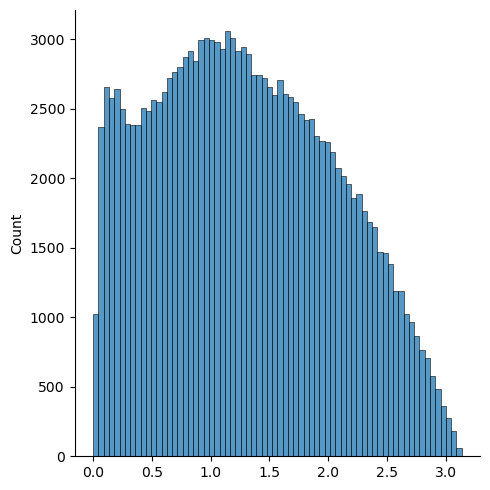

In [25]:
sns.displot(score_high_sigma)

In [ ]:
score_high_sigma.index.astype(int)

In [26]:
results.head()

,Unnamed: 0,direction_x,direction_y,direction_z,direction_kappa,zenith_x,azimuth_x,sigma,azimuth_y,zenith_y
event_id,,,,,,,,,,
1269524767,0,-0.779190,0.190916,-0.572735,1.132755,2.190805,2.901308,0.939576,3.246608,1.179590
1269524769,1,0.416731,0.873912,0.244804,2.582629,1.323139,1.125834,0.622256,4.111630,2.007734
1269524782,2,-0.299758,0.477304,-0.817542,0.891785,2.538006,2.131567,1.058937,5.441680,1.237574
1269524811,3,0.904328,0.184634,0.373901,12.729959,1.185901,0.201399,0.280276,2.510968,2.737970
1269524821,4,0.185656,0.193527,0.838907,0.615145,0.309411,0.806153,1.275003,5.020052,0.722196


In [ ]:
batch_low_sigma = batch[batch["event_id"].isin(score_low_sigma.index.astype(int))]

In [ ]:
batch_high_sigma = batch[batch["event_id"].isin(score_high_sigma.index.astype(int))]

In [ ]:
batch_low_sigma.shape, batch_high_sigma.shape

In [ ]:
batch_high_sigma.head()

予測精度が悪いものは、 charge が低い。

予測精度が良いもののほうが、どちらかというと、 charge が大きい。

In [ ]:
sns.displot(batch_low_sigma.loc[:10000, "charge"])

In [ ]:
sns.displot(batch_high_sigma.loc[:10000, "charge"])

In [ ]:
submission_low_sigma.shape

In [ ]:
submission_low_sigma.head()

In [ ]:
sns.displot(valid_df.reset_index().loc[:300000, ["azimuth", "zenith"]])

In [ ]:
sns.displot(submission_df.reset_index().loc[:300000, ["azimuth", "zenith"]])

In [ ]:
# うまく推論できているものの正解ラベル
sns.displot(valid_low_sigma.reset_index().loc[:300000, ["azimuth", "zenith"]])

In [ ]:
# うまく推論できているものの推論結果
sns.displot(submission_low_sigma.reset_index().loc[:300000, ["azimuth", "zenith"]])

In [ ]:
# 推論できていないものの正解ラベル
sns.displot(valid_high_sigma.reset_index().loc[:300000, ["azimuth", "zenith"]])

In [ ]:
# 「上手に推論できていないニュートリノ」の推論結果
sns.displot(submission_high_sigma.reset_index().loc[:300000, ["azimuth", "zenith"]])

In [ ]:
results_high_sigma.head()

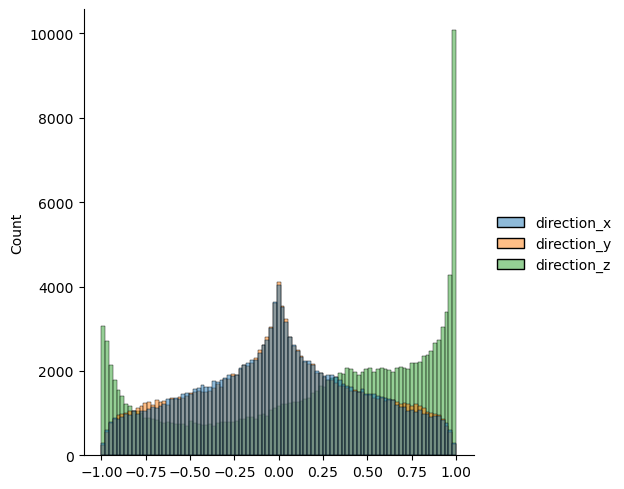

In [27]:
sns.displot(results_high_sigma[["direction_x", "direction_y", "direction_z"]])

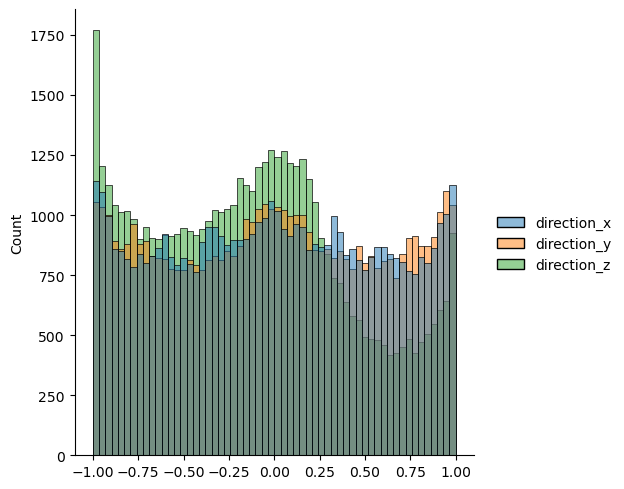

In [28]:
sns.displot(results_low_sigma[["direction_x", "direction_y", "direction_z"]])

In [29]:
input.train_meta["direction_x"] = np.sin(input.train_meta["zenith"]) * np.cos(input.train_meta["azimuth"])
input.train_meta["direction_y"] = np.sin(input.train_meta["zenith"]) * np.sin(input.train_meta["azimuth"])
input.train_meta["direction_z"] = np.cos(input.train_meta["zenith"])

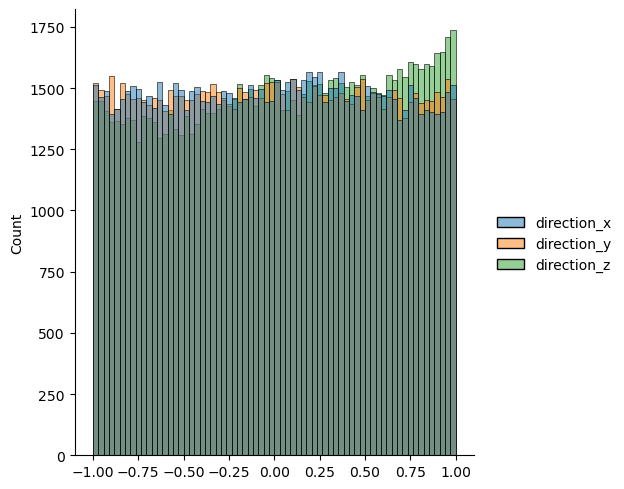

In [30]:
sns.displot(input.train_meta[["direction_x", "direction_y", "direction_z"]][:100000])

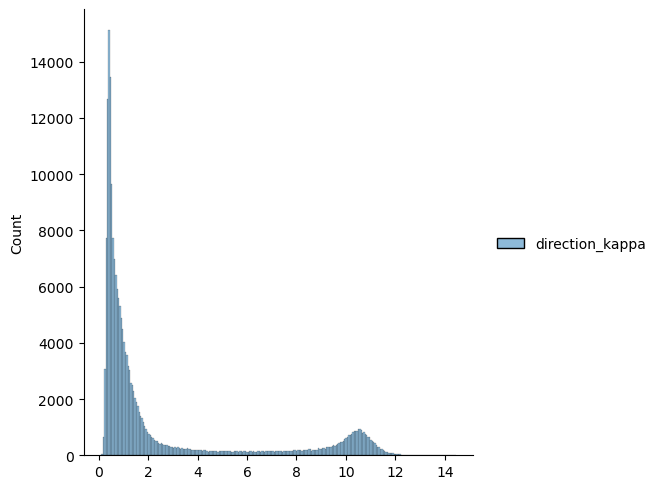

In [41]:
sns.displot(np.sqrt(results[["direction_kappa"]]))

In [33]:
results["sum_direction"] = np.abs(results["direction_x"]) + np.abs(results["direction_y"]) + np.abs(results["direction_z"])

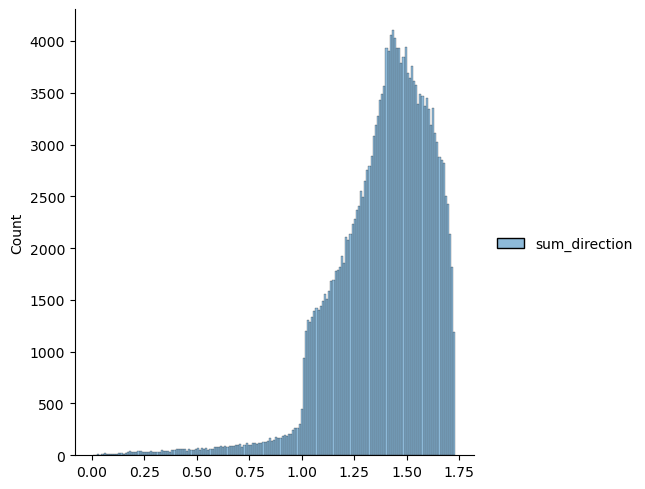

In [34]:
sns.displot(results[["sum_direction"]])

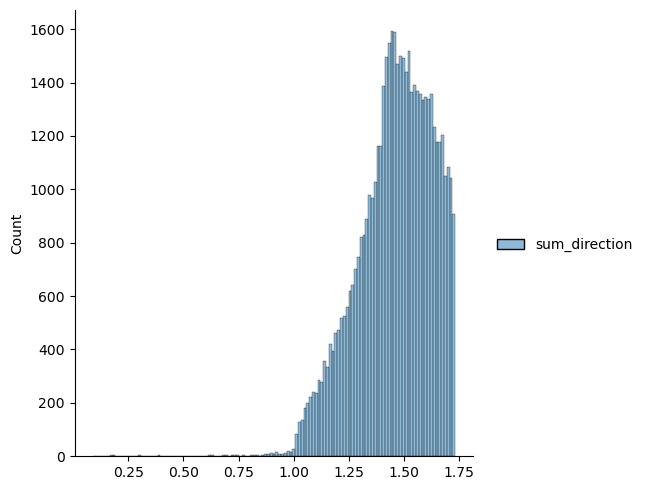

In [37]:
sns.displot(results_low_sigma[["sum_direction"]])

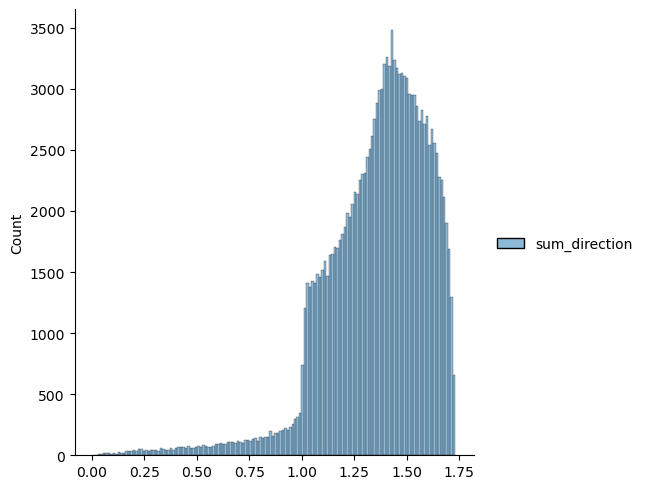

In [38]:
sns.displot(results_high_sigma[["sum_direction"]])

In [39]:
len(results_high_sigma[results_high_sigma["sum_direction"] < 1.0])

7749

In [1]:
import torch

In [2]:
x = torch.randn(3, 5)

In [3]:
x


tensor([[ 1.4596,  1.1513, -1.6438, -1.3931, -1.4477],
        [ 0.4430, -0.2630, -0.4110,  0.0969,  0.0827],
        [ 0.5858, -1.1797,  0.3674,  0.3722,  0.3832]])

In [17]:
torch.cat([torch.flip(x[:, 0:2], [1]), x[:, 2:5]], 1)

tensor([[ 1.1513,  1.4596, -1.6438, -1.3931, -1.4477],
        [-0.2630,  0.4430, -0.4110,  0.0969,  0.0827],
        [-1.1797,  0.5858,  0.3674,  0.3722,  0.3832]])